# O que é a Lei Rouanet

Principal mecanismo de fomento à Cultura do Brasil, a Lei Rouanet, como é conhecida a Lei 8.313/91, instituiu o Programa Nacional de Apoio à Cultura (Pronac). O nome Rouanet remete a seu criador, o então secretário Nacional de Cultura, o diplomata Sérgio Paulo Rouanet. Para cumprir este objetivo, a lei estabelece as normativas de como o Governo Federal deve disponibilizar recursos para a realização de projetos artístico-culturais. A Lei foi concebida originalmente com três mecanismos: o Fundo Nacional da Cultura (FNC), o Incentivo Fiscal e o Fundo de Investimento Cultural e Artístico (Ficart). Este nunca foi implementado, enquanto o Incentivo Fiscal - também chamado de mecenato - prevaleceu e chega ser confundido com a própria Lei.

# Sobre o projeto

Este projeto oferece a oportunidade de compreender melhor a distribuição de recursos culturais por meio da Lei Rouanet e extrair insights significativos sobre a diversidade e impacto dos projetos financiados. 

**Objetivo do projeto**

Realizar uma análise exploratória de dados (EDA) no conjunto de dados da Lei Rouanet, buscando compreender padrões, tendências e insights relacionados aos projetos culturais financiados por meio dessa lei de incentivo à cultura no Brasil.

## Passos do projeto

### 1. Coletar e Carregar os Dados

- Obter o dataset da Lei Rouanet, disponibilizado pelo Ministério da Cultura [(SALIC)](https://api.salic.cultura.gov.br/doc/)
- Carregar os dados em um DataFrame do pandas.

### 2. Realizar uma Exploração Inicial

- Fazer uma exploração inicial para entender a estrutura do dataset, tipos de variáveis e dados disponíveis.

### 3. Limpar e preparar os dados

- Tratar valores ausentes, inconsistências ou duplicatas.
- Converter datas para o formato adequado.
- Analisar, criar e ajustar categorias relevantes.

### 4. Analisar

**4.1. Analisar a distribuição de recursos**

- Explorar a distribuição de recursos financeiros ao longo do tempo.
- Identificar os projetos que receberam a maior e menor quantidade de financiamento.

**4.2. Segmentação por áreas culturais**

- Classificar os projetos por categorias culturais (música, artes cênicas, audiovisual, etc.).
- Analisar a distribuição de recursos por essas diferentes áreas.

**4.3. Participação geográfica**

- Visualizar a participação geográfica dos projetos. Qual região do Brasil recebeu mais incentivos culturais?

**4.4. Evolução ao longo dos anos**

- Criar gráficos de linha ou de área para mostrar a evolução do número de projetos financiados e do montante investido ao longo dos anos.

**4.5. Influência de grandes projetos**

- Identificar e analisar grandes projetos que receberam um montante significativo de financiamento. Como esses projetos influenciam a distribuição geral?

<!-- **4.5. Análise de contrapartidas**

- Explorar as contrapartidas oferecidas pelos proponentes dos projetos. Quais tipos de contrapartidas são mais comuns? -->

<!-- **4.6. Análise de sucesso**

- Definir critérios para o sucesso de um projeto (por exemplo, avaliação do público, impacto cultural) e explorar quais características estão associadas a projetos bem-sucedidos. -->

### 5. Concluir

- Resumir as principais descobertas do projeto.
- Identificar padrões interessantes, tendências ao longo do tempo e qualquer insight que possa ser valioso para as partes interessadas e tomadores de decisão.

## Ferramentas utilizadas

- Python (pandas, numpy, geobr, matplotlib e seaborn)
- Jupyter Notebook para documentação e visualização interativa.

# Análise de Dados Exploratória

<!-- Fontes:
- https://www.linkedin.com/pulse/entenda-o-que-%C3%A9-lei-rouanet-ficarte-fnc-e-oque-fiscal-oliveira/?originalSubdomain=pt
- https://www.gov.br/cultura/pt-br/centrais-de-conteudo/marcas-e-logotipos/copy_of_ManualdoProponenteMduloIApresentaodePropostas1.pdf
- https://portaldoincentivo.com.br/visitors/incentive_laws/1 -->

### 1. Coletar e Carregar os Dados

**Obter o dataset da Lei Rouanet, disponibilizado pelo Ministério da Cultura [(SALIC)](https://api.salic.cultura.gov.br/doc/)**

Desenvolvi um script utilizando as bibliotecas os,  request, port eimport ppara extrair os dados da API referentes aos projetos, propostas, proponentes, incentivadores e fornecedores. Os dados foram salvos em arquivos no formato .xsls. Devido ao seu tamanho, não puderam ser hospedados neste repositório, e, portanto, inclui eles no Googre Drive e compartilhei os links em um arquivo .csv. 

Os arquivos podem ser baixados manualmente, ou utilizando um script que desenvolvi utilizando as bibliotecas os e gdown. 

**Carregar os dados em um DataFrame do pandas.**

In [1]:
from os import path

import numpy as np
import pandas as pd

import geobr
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import seaborn.objects as so

In [2]:
projetos = pd.read_excel(path.abspath("datasets/projetos.xlsx"))
propostas = pd.read_excel(path.abspath("datasets/propostas.xlsx"))
proponentes = pd.read_excel(path.abspath("datasets/proponentes.xlsx"))
incentivadores = pd.read_excel(path.abspath("datasets/incentivadores.xlsx"))
fornecedores = pd.read_excel(path.abspath("datasets/fornecedores.xlsx"))

### 2. Realizar uma Exploração Inicial

**Fazer uma exploração inicial para entender a estrutura do dataset, tipos de variáveis e dados disponíveis.**

Começando pelos projetos...

Colunas interessantes para a análise de dados: 

- `providencia` `situacao`
- `area` `segmento`
- `mecanismo`
- `_links`
- `valor_aprovado` `valor_projeto` `valor_captado` `valor_proposta`
- `UF` `municipio`
- `ano_projeto` `data_termino` `data_inicio`
- `impacto_ambiental`
- `proponente`

In [3]:
projetos.columns

Index(['etapa', 'providencia', 'area', 'enquadramento', 'objetivos',
       'ficha_tecnica', 'situacao', 'outras_fontes', 'acessibilidade',
       'sinopse', 'nome', 'cgccpf', 'mecanismo', '_links', 'segmento',
       'PRONAC', 'estrategia_execucao', 'valor_aprovado', 'justificativa',
       'resumo', 'valor_solicitado', 'especificacao_tecnica', 'municipio',
       'data_termino', 'UF', 'impacto_ambiental', 'democratizacao',
       'valor_projeto', 'proponente', 'ano_projeto', 'data_inicio',
       'valor_captado', 'valor_proposta'],
      dtype='object')

### 3. Limpar e preparar os dados

**Tratar valores ausentes, inconsistências ou duplicatas.**

**Converter datas para o formato adequado.**

**Analisar, criar e ajustar categorias relevantes.**

Dividir estados por regiões do Brasil.

In [10]:
def regiao_do_uf(uf):
    regioes = {
        "Centro Oeste": ["DF", "GO", "MS", "MT"],
        "Nordeste": ["AL", "BA", "CE", "MA", "PB", "PE", "PI", "RN", "SE"],
        "Norte": ["AC", "AM", "AP", "PA", "RO", "RR", "TO"],
        "Sudeste": ["ES", "MG", "RJ", "SP"],
        "Sul": ["PR", "RS", "SC"]
    }
    for regiao, estados in regioes.items():
        if uf in estados:
            return regiao

regioes = pd.Series(projetos["UF"].apply(regiao_do_uf), name="regioes")

if "regioes" not in projetos.columns:
    projetos = pd.concat([projetos, regioes], axis=1)

### 4. Analisar

#### 4.1. Analisar a distribuição de recursos

**Explorar a distribuição de recursos financeiros ao longo do tempo.**

Sobre os mecanismos utilizados pela Lei Rouanet:

- Incentivo Fiscal (mecenato)

O incentivo é um mecanismo em que a União faculta às pessoas físicas ou jurídicas a opção pela aplicação de parcelas do Imposto sobre a Renda, a título de doações ou patrocínios, no apoio direto a projetos culturais aprovados pelo Ministério da Cultura. Ou seja: o Governo Federal oferece uma ferramenta para que a sociedade possa decidir aplicar parte do dinheiro de seus impostos em ações culturais. Desta maneira, o incentivo fiscal estimula a participação da iniciativa privada, do mercado empresarial e dos cidadãos no aporte de recursos para o campo da cultura, diversificando possibilidades de financiamento, ampliando o volume de recursos destinados ao setor, atribuindo a ele mais potência e mais estratégia econômica.

- Fundo Nacional da Cultura (FNC)

O Fundo Nacional da Cultura (FNC) representa o investimento direto do Estado no fomento à Cultura, já que o apoio a projetos decorre de recursos do orçamento da União dentre outras fontes, como 3% do valor bruto arrecado pelas loterias federais e doações. O apoio via FNC tem como objetivo promover a distribuição regional dos recursos de forma equilibrada e é voltado aos projetos com maior dificuldade de captação junto ao mercado.

**Identificar os projetos que receberam a maior e menor quantidade de financiamento.**

#### 4.2. Segmentação por áreas culturais

**Classificar os projetos por categorias culturais (música, artes cênicas, audiovisual, etc.).**

Inicialmente, realizei as contagens dos projetos segmentados por áreas.

In [14]:
areas_por_regioes = projetos.groupby("regioes")["area"].value_counts(normalize=True, sort=False) * 100

medias = np.average(np.array(areas_por_regioes).reshape(5, -1), axis=0) # 5 regiões do Brasil
rotulos = areas_por_regioes['Norte'].index

areas_por_projetos = pd.Series(medias, index=rotulos, name="frequencia_relativa").sort_values(ascending=False)

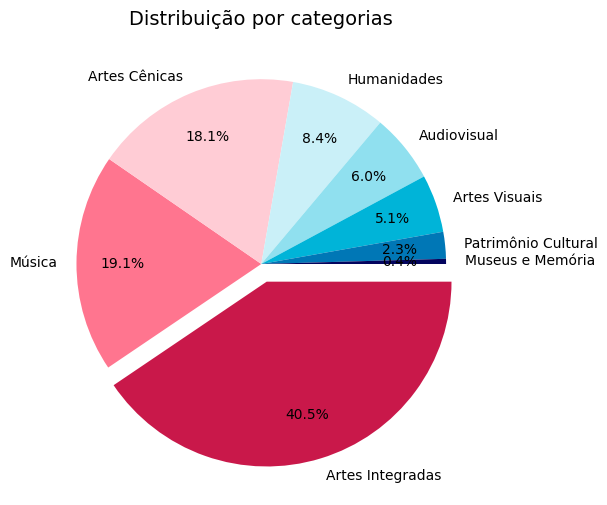

In [15]:
rotulos = areas_por_projetos.index
cores = ["#c9184a", "#ff758f", "#ffccd5", "#caf0f8", 
          "#90e0ef", "#00b4d8", "#0077b6", "#03045e"]
separacao_fatia = (0.1, 0, 0, 0, 0, 0, 0, 0)

plt.rcParams.update({"font.size": 10})

plt.figure(figsize=(6, 6))
plt.title('Distribuição por categorias', fontsize=14)
plt.pie(areas_por_projetos, 
        labels=rotulos, 
        autopct='%1.1f%%', 
        pctdistance=0.75,
        counterclock=False,
        colors=cores, 
        explode=separacao_fatia)

plt.show()

**Analisar a distribuição de recursos por essas diferentes áreas**

#### 4.3. Participação geográfica

**Visualizar a participação geográfica dos projetos.**

Inicialmente, realizei a contagem de projetos por regiões e por estados e plotei os resultados em um gráfico.

In [17]:
warnings.filterwarnings("ignore")

projetos_por_regiao = projetos["regioes"].value_counts().rename("qtd_projetos")
regioes = geobr.read_region() # Download do mapa do Brasil dividido por regiões
regioes = regioes.merge(projetos_por_regiao, how="left", left_on="name_region", right_on="regioes")

projetos_por_estados = projetos["UF"].value_counts().rename("qtd_projetos")
estados = geobr.read_country(year=2020)  # Download do mapa do Brasil dividido por estados
estados = estados.merge(projetos_por_estados, how="left", left_on="abbrev_state", right_on="UF")

(-76.24758052684999, -26.59070825415, -35.70232894755001, 7.222992030549992)

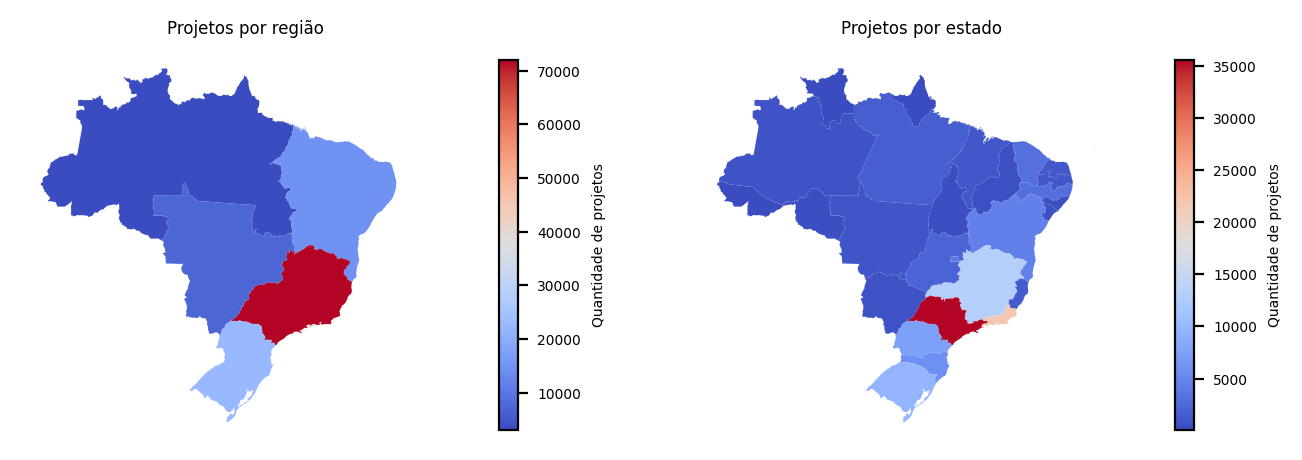

In [18]:
plt.rcParams.update({"font.size": 5})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=200)

regioes.plot(
    column="qtd_projetos",
    cmap="coolwarm",
    legend=True,
    legend_kwds={
        "label": "Quantidade de projetos",
        "orientation": "vertical",
        "shrink": 0.6,
    },
    ax=axes[0],
)

estados.plot(
    column="qtd_projetos",
    cmap="coolwarm",
    legend=True,
    legend_kwds={
        "label": "Quantidade de projetos",
        "orientation": "vertical",
        "shrink": 0.6,
    },
    ax=axes[1],
)

axes[0].set_title("Projetos por região")
axes[0].axis("off")
axes[1].set_title("Projetos por estado")
axes[1].axis("off")

In [19]:
warnings.filterwarnings("default")

#### 4.4. Evolução ao longo dos anos

**Criar gráficos de linha ou de área para mostrar a evolução do número de projetos financiados e do montante investido ao longo dos anos.**

#### 4.5. Influência de grandes projetos

**Identificar e analisar grandes projetos que receberam um montante significativo de financiamento. Como esses projetos influenciam a distribuição geral?**

### 5. Concluir

**Resumir as principais descobertas do projeto.**

**Identificar padrões interessantes, tendências ao longo do tempo e qualquer insight que possa ser valioso para as partes interessadas e tomadores de decisão.**